In [8]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, classification_report, roc_auc_score
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler

In [9]:
warnings.filterwarnings(action='ignore')

In [10]:
# Load Synthetic Data

gaussian_copula = pd.read_csv('Synthetic_data(Gaussian Copula).csv', index_col=False)
gaussian_copula = gaussian_copula.iloc[:,1:]

copula_gan = pd.read_csv('Synthetic_data(Copula GAN).csv', index_col=False)
copula_gan = copula_gan.iloc[:,1:]

ctgan = pd.read_csv('Synthetic_data(CTGAN).csv', index_col=False)
ctgan = ctgan.iloc[:,1:]

tave = pd.read_csv('Synthetic_data(TAVE).csv', index_col=False)
tave = tave.iloc[:,1:]


# Load Train Data
x_df = pd.read_csv('x_df.csv')
x_df = x_df.iloc[:, 1:]

# Load Label Data
y_df_binarized = np.load('y_df_binarized.npy')

# Combined df
full_df = x_df
full_df['dna'] = y_df_binarized

In [18]:
# Data_processing Module
def datasize_check(data, name):
    '''
    Data Size Checking

    Return : data shape and class distribution
    '''
    print(f'Data shape of {name}: {data.shape}')
    print(f'Class Distribution : {Counter(data["dna"])}\n')

def making_valid_data(data, number):
    '''
    60 validation dataset 

    Return Validation data
    '''
    df_0 = data[data['dna'] == 0].sample(number, random_state=42)
    df_1 = data[data['dna'] == 1].sample(number, random_state=42)

    result = pd.concat([df_0, df_1])

    train = data.drop(result.index)

    return train, result

def downsample_data(X_train, y_train, random_state=42):
    
    rus = RandomUnderSampler(random_state=random_state)

    X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

    print(f'\nAfter Down Sampling: {X_train.shape[0]} ----> {X_resampled.shape[0]}')
    print(f'\nDownsampled class distribution: {Counter(y_resampled)}\n')

    return X_resampled, y_resampled


# Model Training Module
def data_split(data, target, size):
    '''
    Train test Data Split

    Return:
    train & test data
    '''
    x_df = data.drop(columns=target)
    y_df = data[target]

    X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, stratify=y_df, test_size=size, random_state=42)

    y_train = np.ravel(y_train)
    y_test = np.ravel(y_test)

    print(f'Train Target Count: {Counter(y_train)}')
    print(f'Test Target Count: {Counter(y_test)}')

    return X_train, X_test, y_train, y_test

def ML_train(X_train, X_test, y_train, y_test, model_name):

    '''
    Machine Learning for   SVM , Logistic, SGD, LGBM

    Return:

    '''

    if model_name == 'SVM':
        
        # Class weight Setting
        class_weight = {0: 2, 1: 1.7}

        # SVM Parmeter Setting
        param_grid = {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto'],
        'kernel': ['linear', 'rbf', 'poly']
        }

        # SVM Model Setting
        model = SVC(random_state=42, class_weight=class_weight)


    elif model_name == 'Logistic':
        # Class weight Setting
        class_weight = {0: 1, 1: 1}

        # Logistic Parmeter Setting
        param_grid = {
        'C': [0.1, 1, 10],
        'penalty' : ['l1', 'l2']
        }

        # Logistic Model Setting
        model = LogisticRegression(random_state=42, class_weight=class_weight)

    elif model_name == 'SGD':
        # Class weight Setting
        class_weight = {0: 2, 1: 3}

        # SGD Parmeter Setting
        param_grid = {
        'alpha': [0.0001, 0.001, 0.01, 0.1],
        'penalty' : ['l1', 'l2']
        }
        # SGD Model Setting
        model = SGDClassifier(random_state=42, class_weight=class_weight)

    elif model_name == 'LGBM':
        # LightGBM Parameter Setting
        param_grid = {
        'learning_rate': [0.01, 0.1, 0.3],
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7]
        }
        # LightGBM Model Setting
        model = LGBMClassifier(random_state=42, scale_pos_weight=3) 

    else:
        print('Check Model Name.')




    # Best Parameter Searching
    result = {}

    # Stratified K-Fold Setting
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    print(f"Training {model_name}...\n")
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=stratified_kfold, scoring='roc_auc_ovr', verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Best Parameters & 5 Fold-cross validation
    cv_results = grid_search.cv_results_

    fold_f1_scores = []
    for i in range(5):
        print(f'Fold {i+1} Training ................\n')

    print(f"Best Parameters for {model_name}:")
    print(grid_search.best_params_)

    # Prediction with best estimator
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    # AUC ROC Calculation
    if model_name == 'LGBM':
        auc_roc = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])
    else:
        auc_roc = roc_auc_score(y_test, best_model.decision_function(X_test))

    # Assessment score present
    print(f"\nTest Result for {model_name}:")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Generate classification report as a dictionary
    report = classification_report(y_test, y_pred, output_dict=True)

    # Store result 
    result[model_name] = {
        'f1_score': report['weighted avg']['f1-score'],
        'accuracy': report['accuracy']
    }

    # Final Results Reporting
    print(f"\n{model_name} Test Results:")
    print(f"{model_name} F1-score : {result[model_name]['f1_score']: .4f}, AUC ROC : {auc_roc:.4f}, Accuracy : {result[model_name]['accuracy']:.4f}")

    return best_model, result
 
def val_result(data, model):
    y_pred = model.predict(data.drop(columns='dna'))
    print(classification_report(data['dna'], y_pred))
    result = classification_report(data['dna'], y_pred, output_dict=True)

    report_df = pd.DataFrame(result).transpose()

    model_name = model.__class__.__name__
    report_df.to_excel(f'{model_name}_classification_result.xlsx')
    
    return report_df



# Visualization module

def vis_bar(results, model_names):

    metrics = ['Accuracy', 'Weighted F1-Score']
    data = []

    for result, name in zip(results, model_names):
        accuracy = result.loc['accuracy', 'precision']
        weighted_f1 = result.loc['weighted avg', 'f1-score']
        data.append([name, accuracy, weighted_f1])

    plot_df = pd.DataFrame(data, columns=["Model", "Accuracy", "Weighted F1-Score"])


    ax = plot_df.set_index('Model').plot(kind='bar', figsize=(8, 6))
    plt.title('Comparison of Model Performance')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.xticks(rotation=0)
    plt.legend(title="Metrics")

    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}',
                    (p.get_x() + p.get_width() / 2, p.get_height()),
                    ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

In [12]:
# Data Size Chekcing
datasize_check(gaussian_copula, 'Gaussian_Copula')
datasize_check(copula_gan, 'Copula_GAN')
datasize_check(ctgan, 'CTGAN')
datasize_check(tave, 'TAVE')
datasize_check(full_df, 'Training Data')

Data shape of Gaussian_Copula: (1841, 737)
Class Distribution : Counter({0: 1578, 1: 263})

Data shape of Copula_GAN: (1841, 737)
Class Distribution : Counter({0: 1578, 1: 263})

Data shape of CTGAN: (1841, 737)
Class Distribution : Counter({0: 1578, 1: 263})

Data shape of TAVE: (1841, 737)
Class Distribution : Counter({0: 1578, 1: 263})

Data shape of Training Data: (357, 737)
Class Distribution : Counter({0: 306, 1: 51})



In [13]:
# Ready for validation dataset
train, val_df = making_valid_data(full_df, 30)

datasize_check(val_df, 'Validation Data')

Data shape of Validation Data: (60, 737)
Class Distribution : Counter({0: 30, 1: 30})



## Gaussian Copula

In [19]:
# Data Split
X_train, X_test, y_train, y_test = data_split(gaussian_copula, 'dna', 0.15)

# Data Sampling
X_train, y_train = downsample_data(X_train, y_train)

svm_model, svm_result = ML_train(X_train, X_test, y_train, y_test, 'SVM')
logi_model, logi_result = ML_train(X_train, X_test, y_train, y_test, 'Logistic')
sgd_model, sgd_result = ML_train(X_train, X_test, y_train, y_test, 'SGD')
lgbm_model, lgbm_result = ML_train(X_train, X_test, y_train, y_test, 'LGBM')

Train Target Count: Counter({0: 1341, 1: 223})
Test Target Count: Counter({0: 237, 1: 40})

After Down Sampling: 1564 ----> 446

Downsampled class distribution: Counter({0: 223, 1: 223})

Training SVM...

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fold 1 Training ................

Fold 2 Training ................

Fold 3 Training ................

Fold 4 Training ................

Fold 5 Training ................

Best Parameters for SVM:
{'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}

Test Result for SVM:
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.86      0.92       237
           1       0.52      0.90      0.66        40

    accuracy                           0.87       277
   macro avg       0.75      0.88      0.79       277
weighted avg       0.91      0.87      0.88       277


SVM Test Results:
SVM F1-score :  0.8798, AUC ROC : 0.9244, Accuracy : 0.8664
Training Logistic...

Fitting 5 folds f

In [20]:
# Save Validation Results
svm_res = val_result(val_df, svm_model)
logi_res = val_result(val_df, logi_model)
sgd_res = val_result(val_df, sgd_model)
lgbm_res = val_result(val_df, lgbm_model)

              precision    recall  f1-score   support

           0       0.78      0.70      0.74        30
           1       0.73      0.80      0.76        30

    accuracy                           0.75        60
   macro avg       0.75      0.75      0.75        60
weighted avg       0.75      0.75      0.75        60

              precision    recall  f1-score   support

           0       0.85      0.77      0.81        30
           1       0.79      0.87      0.83        30

    accuracy                           0.82        60
   macro avg       0.82      0.82      0.82        60
weighted avg       0.82      0.82      0.82        60

              precision    recall  f1-score   support

           0       0.85      0.73      0.79        30
           1       0.76      0.87      0.81        30

    accuracy                           0.80        60
   macro avg       0.81      0.80      0.80        60
weighted avg       0.81      0.80      0.80        60

              preci

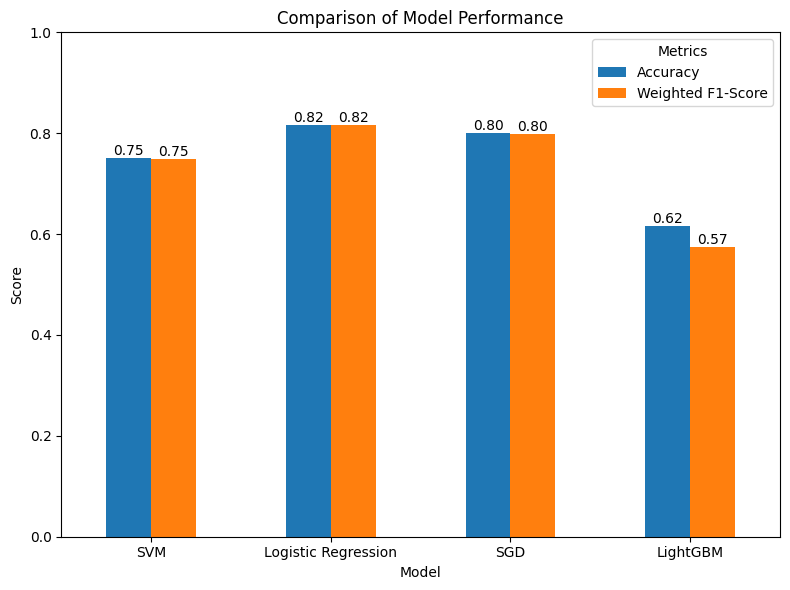

In [21]:
results = [svm_res, logi_res, sgd_res, lgbm_res]
model_names = ["SVM", "Logistic Regression", "SGD", "LightGBM"]

vis_bar(results, model_names)

## Copula GAN

In [22]:
# Data Split
X_train, X_test, y_train, y_test = data_split(copula_gan, 'dna', 0.15)

# Data Sampling
X_train, y_train = downsample_data(X_train, y_train)

svm_model, svm_result = ML_train(X_train, X_test, y_train, y_test, 'SVM')
logi_model, logi_result = ML_train(X_train, X_test, y_train, y_test, 'Logistic')
sgd_model, sgd_result = ML_train(X_train, X_test, y_train, y_test, 'SGD')
lgbm_model, lgbm_result = ML_train(X_train, X_test, y_train, y_test, 'LGBM')

Train Target Count: Counter({0: 1341, 1: 223})
Test Target Count: Counter({0: 237, 1: 40})

After Down Sampling: 1564 ----> 446

Downsampled class distribution: Counter({0: 223, 1: 223})

Training SVM...

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fold 1 Training ................

Fold 2 Training ................

Fold 3 Training ................

Fold 4 Training ................

Fold 5 Training ................

Best Parameters for SVM:
{'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}

Test Result for SVM:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97       237
           1       0.77      1.00      0.87        40

    accuracy                           0.96       277
   macro avg       0.88      0.97      0.92       277
weighted avg       0.97      0.96      0.96       277


SVM Test Results:
SVM F1-score :  0.9589, AUC ROC : 0.9916, Accuracy : 0.9567
Training Logistic...

Fitting 5 folds f

In [23]:
# Save Validation Results
svm_res = val_result(val_df, svm_model)
logi_res = val_result(val_df, logi_model)
sgd_res = val_result(val_df, sgd_model)
lgbm_res = val_result(val_df, lgbm_model)

              precision    recall  f1-score   support

           0       0.51      0.93      0.66        30
           1       0.60      0.10      0.17        30

    accuracy                           0.52        60
   macro avg       0.55      0.52      0.42        60
weighted avg       0.55      0.52      0.42        60

              precision    recall  f1-score   support

           0       0.45      0.50      0.48        30
           1       0.44      0.40      0.42        30

    accuracy                           0.45        60
   macro avg       0.45      0.45      0.45        60
weighted avg       0.45      0.45      0.45        60

              precision    recall  f1-score   support

           0       0.59      0.43      0.50        30
           1       0.55      0.70      0.62        30

    accuracy                           0.57        60
   macro avg       0.57      0.57      0.56        60
weighted avg       0.57      0.57      0.56        60

              preci

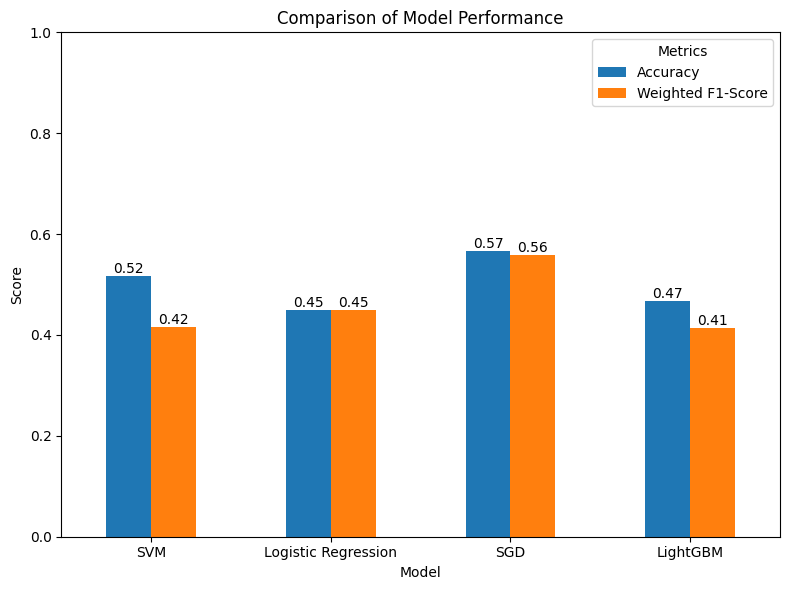

In [24]:
results = [svm_res, logi_res, sgd_res, lgbm_res]
model_names = ["SVM", "Logistic Regression", "SGD", "LightGBM"]

vis_bar(results, model_names)

## CTGAN

In [25]:
# Data Split
X_train, X_test, y_train, y_test = data_split(ctgan, 'dna', 0.15)

# Data Sampling
X_train, y_train = downsample_data(X_train, y_train)

svm_model, svm_result = ML_train(X_train, X_test, y_train, y_test, 'SVM')
logi_model, logi_result = ML_train(X_train, X_test, y_train, y_test, 'Logistic')
sgd_model, sgd_result = ML_train(X_train, X_test, y_train, y_test, 'SGD')
lgbm_model, lgbm_result = ML_train(X_train, X_test, y_train, y_test, 'LGBM')

Train Target Count: Counter({0: 1341, 1: 223})
Test Target Count: Counter({0: 237, 1: 40})

After Down Sampling: 1564 ----> 446

Downsampled class distribution: Counter({0: 223, 1: 223})

Training SVM...

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fold 1 Training ................

Fold 2 Training ................

Fold 3 Training ................

Fold 4 Training ................

Fold 5 Training ................

Best Parameters for SVM:
{'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}

Test Result for SVM:
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       237
           1       0.71      0.93      0.80        40

    accuracy                           0.94       277
   macro avg       0.85      0.93      0.88       277
weighted avg       0.95      0.94      0.94       277


SVM Test Results:
SVM F1-score :  0.9384, AUC ROC : 0.9784, Accuracy : 0.9350
Training Logistic...

Fitting 5 folds f

In [26]:
# Save Validation Results
svm_res = val_result(val_df, svm_model)
logi_res = val_result(val_df, logi_model)
sgd_res = val_result(val_df, sgd_model)
lgbm_res = val_result(val_df, lgbm_model)

              precision    recall  f1-score   support

           0       0.45      0.70      0.55        30
           1       0.31      0.13      0.19        30

    accuracy                           0.42        60
   macro avg       0.38      0.42      0.37        60
weighted avg       0.38      0.42      0.37        60

              precision    recall  f1-score   support

           0       0.45      0.63      0.53        30
           1       0.39      0.23      0.29        30

    accuracy                           0.43        60
   macro avg       0.42      0.43      0.41        60
weighted avg       0.42      0.43      0.41        60

              precision    recall  f1-score   support

           0       0.42      0.57      0.49        30
           1       0.35      0.23      0.28        30

    accuracy                           0.40        60
   macro avg       0.39      0.40      0.38        60
weighted avg       0.39      0.40      0.38        60

              preci

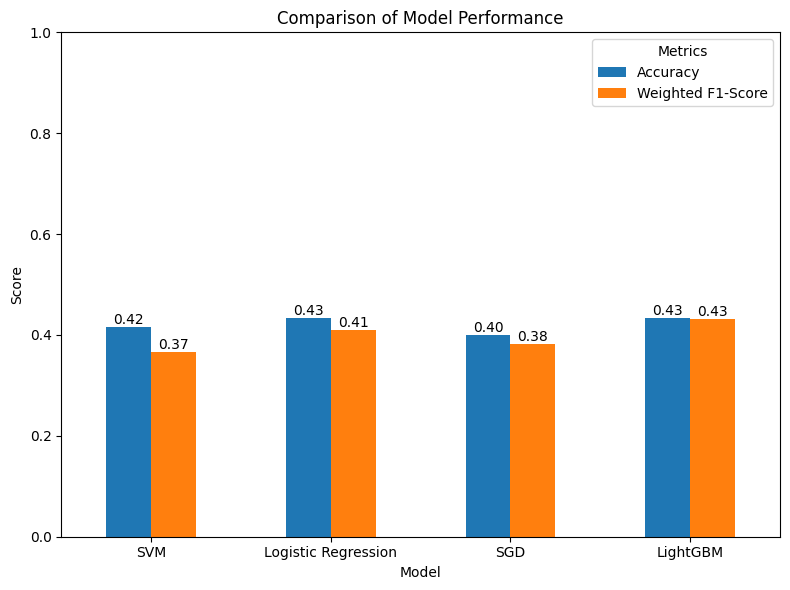

In [27]:
results = [svm_res, logi_res, sgd_res, lgbm_res]
model_names = ["SVM", "Logistic Regression", "SGD", "LightGBM"]

vis_bar(results, model_names)

## TAVE

In [28]:
# Data Split
X_train, X_test, y_train, y_test = data_split(tave, 'dna', 0.15)

# Data Sampling
X_train, y_train = downsample_data(X_train, y_train)

svm_model, svm_result = ML_train(X_train, X_test, y_train, y_test, 'SVM')
logi_model, logi_result = ML_train(X_train, X_test, y_train, y_test, 'Logistic')
sgd_model, sgd_result = ML_train(X_train, X_test, y_train, y_test, 'SGD')
lgbm_model, lgbm_result = ML_train(X_train, X_test, y_train, y_test, 'LGBM')

Train Target Count: Counter({0: 1341, 1: 223})
Test Target Count: Counter({0: 237, 1: 40})

After Down Sampling: 1564 ----> 446

Downsampled class distribution: Counter({0: 223, 1: 223})

Training SVM...

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fold 1 Training ................

Fold 2 Training ................

Fold 3 Training ................

Fold 4 Training ................

Fold 5 Training ................

Best Parameters for SVM:
{'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}

Test Result for SVM:
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       237
           1       0.81      0.95      0.87        40

    accuracy                           0.96       277
   macro avg       0.90      0.96      0.93       277
weighted avg       0.96      0.96      0.96       277


SVM Test Results:
SVM F1-score :  0.9616, AUC ROC : 0.9945, Accuracy : 0.9603
Training Logistic...

Fitting 5 folds f

In [29]:
# Save Validation Results
svm_res = val_result(val_df, svm_model)
logi_res = val_result(val_df, logi_model)
sgd_res = val_result(val_df, sgd_model)
lgbm_res = val_result(val_df, lgbm_model)

              precision    recall  f1-score   support

           0       0.57      0.97      0.72        30
           1       0.89      0.27      0.41        30

    accuracy                           0.62        60
   macro avg       0.73      0.62      0.56        60
weighted avg       0.73      0.62      0.56        60

              precision    recall  f1-score   support

           0       0.57      0.97      0.72        30
           1       0.89      0.27      0.41        30

    accuracy                           0.62        60
   macro avg       0.73      0.62      0.56        60
weighted avg       0.73      0.62      0.56        60

              precision    recall  f1-score   support

           0       0.53      0.70      0.60        30
           1       0.55      0.37      0.44        30

    accuracy                           0.53        60
   macro avg       0.54      0.53      0.52        60
weighted avg       0.54      0.53      0.52        60

              preci

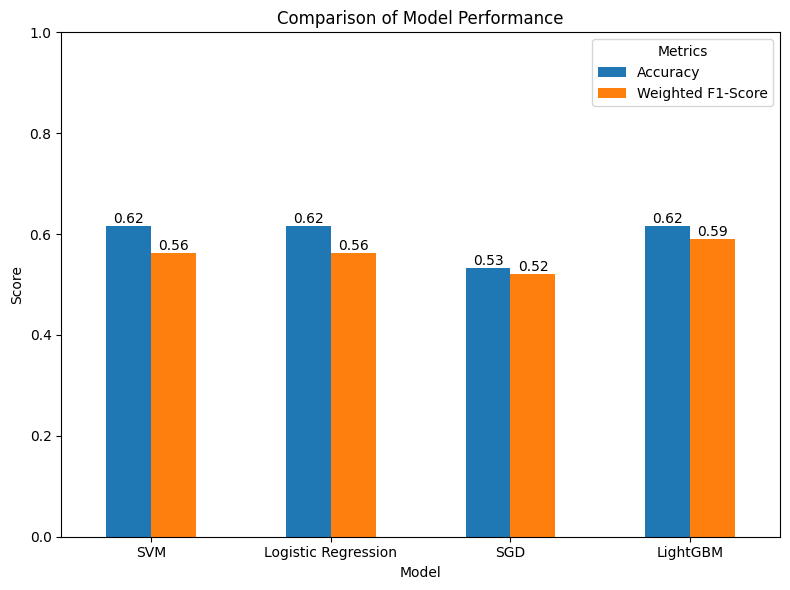

In [30]:
results = [svm_res, logi_res, sgd_res, lgbm_res]
model_names = ["SVM", "Logistic Regression", "SGD", "LightGBM"]

vis_bar(results, model_names)